In [1]:
import sympy as sp
sp.init_printing()

In [2]:
space = sp.var('x, y, z')
x, y, z = space
vec_x = sp.Matrix(space)

angle = sp.var(r'theta, phi')
th, ph = angle
vec_om = sp.Matrix([sp.sin(ph)*sp.cos(th), sp.sin(ph)*sp.sin(th), sp.cos(ph)])

angle_prime = sp.var(r'theta_p, phi_p')
thp, php = angle_prime
vec_omp = sp.Matrix([sp.sin(php)*sp.cos(thp), sp.sin(php)*sp.sin(thp), sp.cos(php)])

In [3]:
def grad(expr, space=space):
    return sp.Matrix([sp.diff(expr, d) for d in space])

In [4]:
def sphere_integral(expr, angle):
    theta, phi = angle
    return sp.integrate(expr*sp.sin(phi), (theta, 0, 2*sp.pi), (phi, 0, sp.pi))

In [5]:
def dot(a, b):
    return sum(a.T * b)

---

In [12]:
def calculate_a(L, b, beta, params=()):
    """
    Calculate absorption coefficients over space to produce manufactured solution L.
    
    L sholud be a function of 5 variables (+ params),
    and beta should be a function of 1 variable.
    params is an iterable containing any parameters for L
    """
    
    L_om = L(*space, *angle, *params)
    L_omp = L(*space, *angle_prime, *params)
    
    integrand1 = dot(vec_om, grad(L_om)) / L_om
    integral1 = sphere_integral(integrand1, angle=angle)
    
    integrand2 = beta(dot(vec_om, vec_omp)) * L_omp / L_om
    integral2 = sphere_integral(
        sphere_integral(
            integrand2, 
            angle=angle
        ),
        angle=angle_prime
    )
    
    return -b - integral1/(4*sp.pi) + b*integral2/(4*sp.pi)

In [13]:
b = sp.var('b')
params = sp.var('alpha, gamma')

In [14]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [15]:
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (2+sp.sin(2*sp.pi*x/alpha))*(2+sp.sin(2*sp.pi*y/alpha))*(1+sp.tanh(z-gamma))*(2+sp.sin(phi))

In [16]:
prod_a = calculate_a(prod_L, b, uniform_vsf, params)

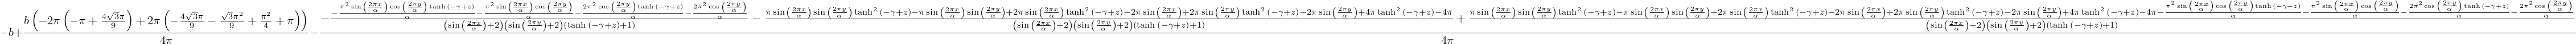

In [17]:
prod_a

In [18]:
prod_L_om = prod_L(x, y, z, th, ph, *params)
prod_L_omp = prod_L(x, y, z, thp, php, *params)

In [19]:
deriv = dot(vec_om, grad(prod_L_om))
atten = (prod_a + b) * prod_L_om
scat = b * sphere_integral(uniform_vsf(dot(vec_om, vec_omp))*prod_L_omp, angle=angle_prime)

In [42]:
f = sp.lambdify(
    ('x', 'y', 'z', 'b', 'alpha','gamma'), 
    sphere_integral(
        (deriv + atten - scat),
        angle=angle
    )
)

In [43]:
f1 = lambda x, y, z: f(x, y, z, b=0, alpha=1, gamma=0.5)

In [39]:
f1(1,1,1)

AttributeError: 'Symbol' object has no attribute 'sin'